## Quickstart with the active learning module

[Active learning]( https://en.wikipedia.org/wiki/Active_learning_(machine_learning) ) is a method that aims to collect and labelled new data in order to improve the machine learning model. Based on a predefined heuristic strategy, a certain number of data will be annotated and used to re-train the model. 
In pyrelational, we use: 
- an active learning ``strategy``, that query new data points based on specific selection criterion;
- a ``model manager`` that takes in input an uninstantiated ML model and a set of arguments (ie: the number of epochs) used for training;
- a ``data_manager`` that will update, after each query, the pool of labelled and unlabelled data; 
- an ``oracle``, at the interface between the data manager and the strategy, it gives the user the ability to access the queried data and manually annotate it with external tools. The oracle is optional; 
- a ``pipeline`` that aims to manage the strategy, the model and the data manager together.

## The dataset

We will use the sklearn [digits dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) where each datapoint is a 8x8 image of a digit that we aim to classify with a neural network.

We are defining a data manager that will update the pool of labelled data used to train the model. The validation set and the test set are fixed, and they will always remained unchanged. In the following example, we have 9000 unlabelled images, which we aim to query, based on a specific strategy, and annotate, to improve the model performances.

In [6]:
import torch
from torchvision import datasets, transforms
from pyrelational.data_managers import DataManager

# creating the dataset with pytorch
dataset = datasets.FashionMNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
dataset = [dataset[i] for i in range(10000)]
train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [9000, 500, 500])
train_indices = train_ds.indices
val_indices = val_ds.indices
test_indices = test_ds.indices

# creating the data manager
data_manager = DataManager(
    dataset=dataset,
    train_indices=train_indices,
    validation_indices=val_indices,
    test_indices=test_indices,
    loader_batch_size=1000,
)

## The model manager

The model manager here is build with the [Pytorch Lightning module](https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html). 
It needs three inputs: 
- a `model class` that contains the core structure of the model and can contain some hyperparameters such as the number of layers or the dropout rate.
- a `model configuration` dictionary that contains the values for the hyperparameters. It can be empty if no parameters are defined.
- a `trainer configuration` dictionary with all the parameters needed for training, written in a pytorch lightning fashion. The default dictionnary can be inspected in the `models/lightning_model.py` file.

In [7]:
from pyrelational.model_managers import LightningMCDropoutModelManager
from examples.utils.ml_models import MnistClassification  # noqa: E402

model_manager = LightningMCDropoutModelManager(
    model_class=MnistClassification, 
    model_config={"dropout": 0.2}, 
    trainer_config={"epochs": 4})

/Users/alpu/miniconda3/envs/pyrelational/lib/python3.10/site-packages/pytorch_lightning/core/lightning.py:22: LightningDeprecationWarning: pytorch_lightning.core.lightning.LightningModule has been deprecated in v1.7 and will be removed in v1.9. Use the equivalent class from the pytorch_lightning.core.module.LightningModule class instead.
  rank_zero_deprecation(


## The query strategy and the active learning loop

Using more labelled data for training improves the model performances. Yet, labelling data can be time-consuming and some data may be more influential. The idea is to query the most informative data that aim to be annotated. The informativeness of the data depends on the strategy used. In this example, we are considering four different strategies designed for a classification task: 

- `least confidence strategy` aim to query samples whose predictions are the most uncertain;
- `marginal confidence strategy` computes the difference between the top and second top prediction: the lower is this difference, the highest is the score;
- `ratio confidence strategy` is similar to the marginal confidence strategy except that the score is computed as a ratio between the top and the second top predictions;
- `entropy classification strategy` returns the Shannon entropy of the predictions.

In [8]:
%%capture

from pyrelational.pipeline import Pipeline
from pyrelational.strategies.classification import (
    LeastConfidenceStrategy,
    MarginalConfidenceStrategy,
    RatioConfidenceStrategy,
    EntropyClassificationStrategy,
)

query = dict()
strategies = [LeastConfidenceStrategy,
                 MarginalConfidenceStrategy, 
                 RatioConfidenceStrategy, 
                 EntropyClassificationStrategy]

for strategy in strategies:
    # the data manager is reinitialized for each strategy
    data_manager = DataManager(
        dataset=dataset,
        train_indices=train_indices,
        validation_indices=val_indices,
        test_indices=test_indices,
        loader_batch_size=1000,
    )
    pipeline = Pipeline(data_manager=data_manager, model_manager=model_manager, strategy=strategy())

    # we will annotate 1000 points step by step until there is no more unlabelled training data
    # The training pool consists of 9000 points, so we will annotate all the points in 9 runs
    pipeline.run(num_annotate=1000)
    query[strategy.__name__] = pipeline


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | layer_1 | Linear  | 100 K 
1 | layer_2 | Linear  | 33.0 K
2 | layer_3 | Linear  | 2.6 K 
3 | dropout | Dropout | 0     
------------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.544     Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=4` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.

We can look at a specific strategy: after each iteration, the test accuracy should increase. More metrics can be stored in the pipeline, as long as they are logged in the model class.

In [9]:
# print performance after each iteration for one strategy
query['MarginalConfidenceStrategy'].performance_history()

,Iteration,test_accuracy,test_loss
0,0,0.496,2.070976
1,1,0.360,1.864022
2,2,0.614,1.360989
3,3,0.678,1.099601
4,4,0.716,0.952769
5,5,0.714,0.898642
6,6,0.672,0.976846
7,7,0.740,0.767458
8,8,0.738,0.756951
9,9,0.730,0.783362


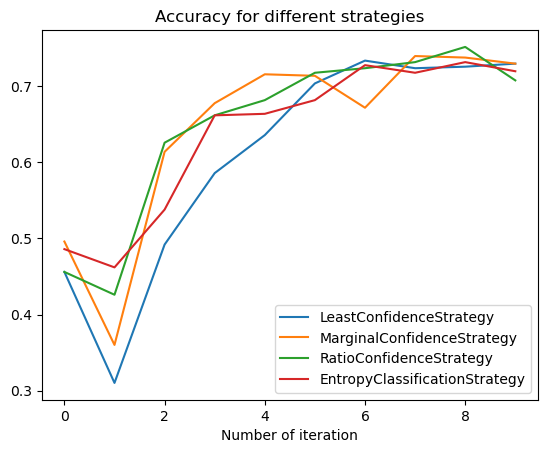

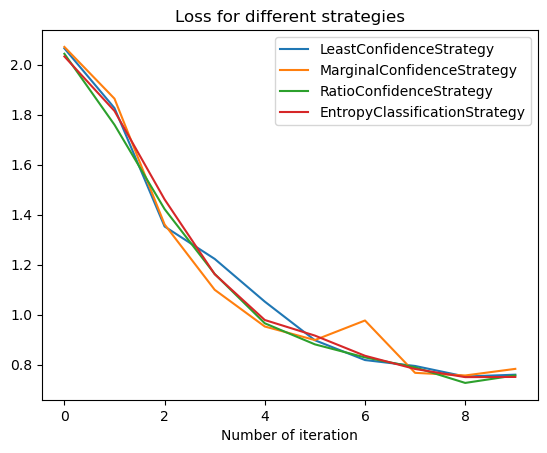

In [10]:
import matplotlib.pyplot as plt

for strategy in strategies :
    df = query[strategy.__name__].performance_history()
    plt.plot(df['test_accuracy'], label=strategy.__name__)
    plt.legend()
    plt.xlabel('Number of iteration')
    plt.title('Accuracy for different strategies')
plt.show()

for strategy in strategies :
    df = query[strategy.__name__].performance_history()
    plt.plot(df['test_loss'], label=strategy.__name__)
    plt.legend()
    plt.xlabel('Number of iteration')
    plt.title('Loss for different strategies')
plt.show()